# S2: All cells QC

In [1]:
# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# read raw data (expression data) to pandas df
pre_adata = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190115_big_counts.txt', 
                      index_col=[0])
                .rename(columns = {'gene':'gene_name'})
                .set_index('gene_name'))
cell_names = ['_'.join(x.split('_')[:2]) for x in pre_adata.columns]
pre_adata.columns = cell_names

# read fetal supp data
pre_adata_supp1 = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190319_fetal_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# read adult supp data
pre_adata_supp2 = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190417_adult_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# merge with raw
pre_adata = pd.concat([pre_adata, pre_adata_supp1,pre_adata_supp2], axis=1)
cell_names = pre_adata.columns.tolist()

# metadata:
## download lastest from google drive and push to s3
meta_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190417_mel_metadata.csv')
meta_df = meta_df.drop(['GWAS_consent', 
                        'sort_info_exported',
                       'sort_date',
                       'plate_order',
                       'sample_number',
                       'plate_status'], axis = 1)
possible_wells = [f'{y}{x}'for y in string.ascii_uppercase[:-10] for x in range(1,25)]
all_wells_df = pd.DataFrame()
for plate in meta_df.plate_barcode:
    well_df = pd.DataFrame({'well':possible_wells})
    well_df['plate_barcode'] = plate
    all_wells_df = pd.concat([all_wells_df, well_df], axis = 0)
    
meta_df = pd.merge(meta_df, all_wells_df, 'left', 'plate_barcode')
meta_df['cell_name'] = [f'{x}_{y}' for x,y in zip(meta_df.well, meta_df.plate_barcode)]

merged_anno = pd.merge(pd.DataFrame({'cell_name':cell_names}), meta_df, 'left', 'cell_name')
merged_anno = merged_anno.set_index('cell_name')


/home/ubuntu/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy version: 1.4.4.post1


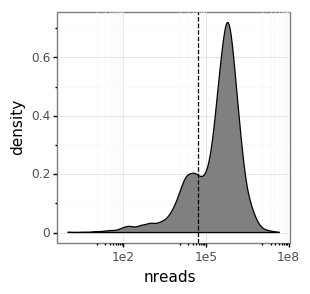

<ggplot: (8730536715384)>


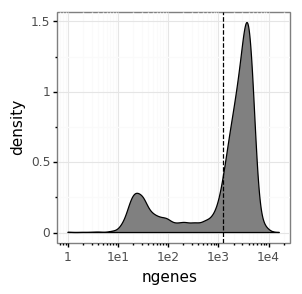

<ggplot: (-9223363306321514657)>


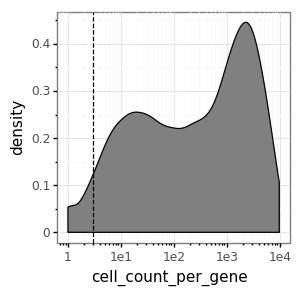

<ggplot: (-9223363306323022953)>


In [8]:
# nreads
dist_df = pd.DataFrame({'nreads':pre_adata.astype(int).sum().values,
                        'ngenes':(pre_adata > 0).sum().values,
                        'cell_id':pre_adata.columns
                       }).set_index('cell_id')
plotnine.options.figure_size = (3,3)

plot = (ggplot(dist_df)
        + theme_bw()
        + geom_density(aes('nreads'), fill='grey')
        + geom_vline(aes(xintercept=50000), linetype='--')
        + scale_x_log10()
       )
print(plot)

# ngenes
plot = (ggplot(dist_df)
        + theme_bw()
        + geom_density(aes('ngenes'), fill='grey')
        + geom_vline(aes(xintercept=1250), linetype='--')
        + scale_x_log10()
       )
print(plot)

passing_cells = (dist_df
                 .query('nreads >= 50000')
                 .query('ngenes >= 1250')
                 .reset_index()['cell_id']
                 .tolist()
                )
filtered_pre_adata = pre_adata.loc[:, passing_cells]
dist_df2 = pd.DataFrame({'cell_count_per_gene':(filtered_pre_adata > 0).sum(axis=1)
                       })

# n cells per gene
plot = (ggplot(dist_df2)
        + theme_bw()
        + geom_density(aes('cell_count_per_gene'), fill='grey')
        + geom_vline(aes(xintercept=3), linetype='--')
        + scale_x_log10()
       )
print(plot)

### SRA upload

In [3]:
# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['raw_adata', 
             'full_adata',
             'DE_df',
            ]:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
usable_cores = multiprocessing.cpu_count()-1

In [27]:
source_dict = {'10WK03':'Laurence Baskin',
             '12WK05':'Laurence Baskin',
             '12WKM01':'Laurence Baskin',
             '16WKM04':'Laurence Baskin',
             '18WKM06':'Laurence Baskin',
             '9.5WK02':'Laurence Baskin',
             'A1011L':'Aaron D. Tward',
             'A1012M':'Aaron D. Tward',
             'A1014L':'Scott VandenBerg (UCSF BIOS)',
             'A1015LM':'Aaron D. Tward',
             'A1016LM':'Scott VandenBerg (UCSF BIOS)',
             'A1017LM':'Scott VandenBerg (UCSF BIOS)',
             'A1020LM':'Aaron D. Tward',
             'A1021M':'Scott VandenBerg (UCSF BIOS)',
             'A1022M':'Aaron D. Tward',
             'A1025L':'Scott VandenBerg (UCSF BIOS)',
             'A1026L':'Scott VandenBerg (UCSF BIOS)',
             'A1033M':'Scott VandenBerg (UCSF BIOS)',
             'A1038LM':'Scott VandenBerg (UCSF BIOS)',
             'A1046M':'Scott VandenBerg (UCSF BIOS)',
             'FS030_LM':'Thea Mauro',
             'FS043_LM':'Thea Mauro',}


In [39]:
# biosample attributes TSV
biosampledf = (full_adata
               .obs
               .loc[:,['patient','true_year','sex']]
               .reset_index()
               .rename(columns={'index':'sample_name',
                                'true_year':'age',
                                'patient':'isolate'
                               })
              )

biosampledf['biomaterial_provider'] = [source_dict.get(x) for x in biosampledf['isolate']]
biosampledf['organism'] = 'Homo sapiens'
biosampledf['tissue'] = 'Skin'
biosampledf = biosampledf.loc[:, ['sample_name',
                                  'organism',
                                  'isolate',
                                  'age',
                                  'biomaterial_provider',
                                  'sex',
                                  'tissue',
                                 ]
                             ]
biosampledf['age'] = [f'{x} yr' for x in biosampledf['age']]
biosampledf.to_csv('/home/ubuntu/s3_dump/biosample.tsv', 
                   index=False,
                   sep='\t'
                  )


In [50]:
# metadata tsv
md5_output = '/home/ubuntu/s3_dump/files.md5'
md5_df = pd.read_csv(md5_output, sep ='  ', header=None)
md5_df.columns=['MD5_checksum','filename']
md5_df['sample_name'] = [x[:-4] for x in md5_df['filename']]
# filter to coi
md5_df = pd.merge(biosampledf.loc[:,'sample_name'],
                  md5_df,
                  'left',
                  'sample_name'
                 )
md5_df['filetype'] = 'bam'
md5_df['forward_read_length'] = 100
md5_df['reverse_read_length'] = 100
md5_df['alignment_software'] = 'STAR v2.5.2b'
md5_df['reference_genome_assembly'] = 'hg38'
md5_df['design_description'] = 'smart-seq2'
md5_df['instrument_model'] = 'unspecified'
md5_df['platform'] = 'ILLUMINA'
md5_df['library_layout'] = 'paired'
md5_df['library_selection'] = 'other'
md5_df['library_source'] = 'TRANSCRIPTOMIC'
md5_df['library_strategy'] = 'RNA-Seq'
md5_df['title/short description'] = 'single-cell RNAseq of human melanocytes'
md5_df['library_ID'] = md5_df['sample_name'].values

#### TBD####
md5_df['biosample_accession'] = 'tbd'
md5_df['bioproject_accession'] = 'tbd'
#### TBD####

md5_df = md5_df.loc[:, ['bioproject_accession',
                        'biosample_accession',
                        'sample_name',
                        'library_ID',
                        'title/short description',
                        'library_strategy',
                        'library_source',
                        'library_selection',
                        'library_layout',
                        'platform',
                        'instrument_model',
                        'design_description',
                        'reference_genome_assembly',
                        'alignment_software',
                        'forward_read_length',
                        'reverse_read_length',
                        'filetype',
                        'filename',
                        'MD5_checksum',]]
md5_df.to_csv('/home/ubuntu/s3_dump/metadata.tsv', 
                   index=False,
                   sep='\t'
                  )


In [56]:
# clean bam dir of unused files
allbams = glob.glob('/home/ubuntu/s3_dump/bams/*.bam')
bams_oi = [f'/home/ubuntu/s3_dump/bams/{x}' for x in md5_df['filename']]
omitbams = list(set(allbams) - set(bams_oi))
for f in omitbams:
    ! rm {f}